In [27]:
import os
import random
import sys
from functools import partial

import matplotlib.pyplot as plt

from core.generator import gen_u_step, gen_u_daily_sine
from core.lettuce_model import lettuce_growth_model
from core.simulate import simulate

random.seed(40)

In [28]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# Setup Google Colab Environment
if "google.colab" in sys.modules:
    from google.colab import drive, userdata

    drive.mount("/content/drive")
    os.chdir(userdata.get("project_path"))
    !git pull
    !git checkout dev
    !git pull
    %pip install -r requirements-dev.txt
    !pre-commit install --hook-type pre-push

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
From https://github.com/MarekWadinger/dynamic_opt_growth_model
   99ba774..12f7f38  dev        -> origin/dev
Already up to date.
M	main.ipynb
Already on 'dev'
Your branch is up to date with 'origin/dev'.
Already up to date.
pre-commit installed at .git/hooks/pre-push


In [ ]:
# Commit changes
if "google.colab" in sys.modules:
    !git add -A
    name = userdata.get("github_name")
    email = userdata.get("github_email")
    !git -c user.name="$name" user.email="$email" commit -m "FIX: Githu"

Author identity unknown

*** Please tell me who you are.

Run

  git config --global user.email "you@example.com"
  git config --global user.name "Your Name"

to set your account's default identity.
Omit --global to set the identity only in this repository.

fatal: unable to auto-detect email address (got 'root@db60bf545228.(none)')


In [ ]:
# Push changes to GitHub
if "google.colab" in sys.modules:
    token = userdata.get("github_token")
    !git push https://$token@github.com/MarekWadinger/dynamic_opt_growth_model.git

In [ ]:
x0 = [0.72, 2.7]  # Vanhenten 1994
u_min = [10, 0, 400]
u_max = [25, 100, 800]

In [ ]:
u = partial(gen_u_daily_sine, u_min=u_min, u_max=u_max)

t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=u, sim_time=1200, t_s=60 * 60, x0=x0
)

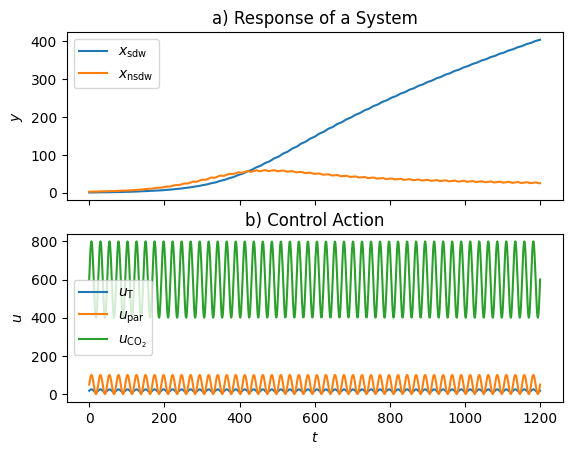

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
axs[0].plot(
    t_out, y_out, label=[r"$x_{\mathrm{sdw}}$", r"$x_{\mathrm{nsdw}}$"]
)
# axs[0].plot(t_out, y_ref[:,0], label=r'$y_{\mathrm{ref}}$', linestyle=":")
axs[0].set_ylabel("$y$")
axs[0].set_title("a) Response of a System")
axs[0].legend()

axs[1].plot(
    t_out,
    u_out,
    label=[r"$u_{\mathrm{T}}$", r"$u_{\mathrm{par}}$", r"$u_{\mathrm{CO_2}}$"],
)
# color = {'color': axs[1]._get_lines.get_next_color()}
# axs[1].axhline(0, **color, linestyle=":")
# axs[1].axhline(400, **color, linestyle=":")
axs[1].set_xlabel("$t$")
axs[1].set_ylabel("$u$")
axs[1].set_title("b) Control Action")
axs[1].legend()

plt.show()

In [ ]:
u = partial(gen_u_step, u_min=u_min, u_max=u_max)
t_out, y_out, u_out = simulate(
    lettuce_growth_model, u=u, sim_time=168, t_s=60 * 60, x0=[0.72, 2.7]
)

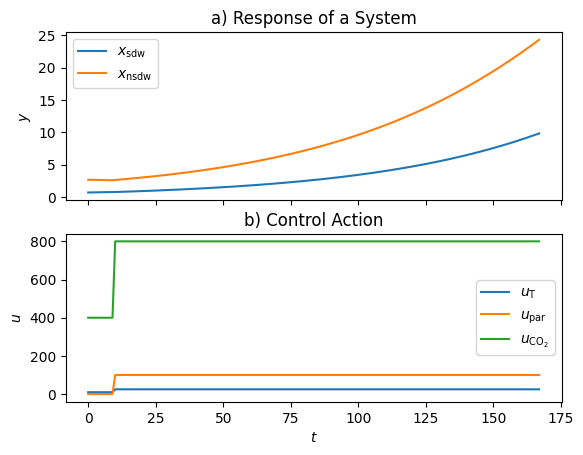

In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
axs[0].plot(
    t_out, y_out, label=[r"$x_{\mathrm{sdw}}$", r"$x_{\mathrm{nsdw}}$"]
)
# axs[0].plot(t_out, y_ref[:,0], label=r'$y_{\mathrm{ref}}$', linestyle=":")
axs[0].set_ylabel("$y$")
axs[0].set_title("a) Response of a System")
axs[0].legend()

axs[1].plot(
    t_out,
    u_out,
    label=[r"$u_{\mathrm{T}}$", r"$u_{\mathrm{par}}$", r"$u_{\mathrm{CO_2}}$"],
)
# color = {'color': axs[1]._get_lines.get_next_color()}
# axs[1].axhline(0, **color, linestyle=":")
# axs[1].axhline(400, **color, linestyle=":")
axs[1].set_xlabel("$t$")
axs[1].set_ylabel("$u$")
axs[1].set_title("b) Control Action")
axs[1].legend()

plt.show()